In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Maze Generator

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class Maze:
    def __init__(self, size=50, seed=None):
        self.size = size
        if seed is not None:
            random.seed(seed)
        # 1 = wall, 0 = path
        self.grid = np.ones((size, size), dtype=int)
        self.start = (0, 0)
        self.goal = None
        self._generate_maze()   # make a perfect maze first

    def _generate_maze(self):
        """
        DFS maze where we move in steps of 2 cells and knock down the wall between.
        This keeps real walls and guarantees connectivity.
        """
        n = self.size
        self.grid[0, 0] = 0  # start is open

        def neighbors2(r, c):
            # move 2 cells at a time
            dirs = [(-2,0),(2,0),(0,-2),(0,2)]
            random.shuffle(dirs)
            for dr, dc in dirs:
                nr, nc = r + dr, c + dc
                if 0 <= nr < n and 0 <= nc < n:
                    yield nr, nc, dr, dc

        def dfs(r, c):
            for nr, nc, dr, dc in neighbors2(r, c):
                if self.grid[nr, nc] == 1:  # not carved yet
                    # knock down wall BETWEEN (r,c) and (nr,nc)
                    wall_r = r + dr // 2
                    wall_c = c + dc // 2
                    self.grid[wall_r, wall_c] = 0
                    self.grid[nr, nc] = 0
                    dfs(nr, nc)

        dfs(0, 0)

    # ---------- EXTRA: create multiple routes ----------
    def add_loops(self, loop_factor=0.05):
        """
        After we have a perfect maze, open some walls between two open cells
        to create alternative routes (loops).
        loop_factor: 0.0 - 0.2 is reasonable.
        """
        n = self.size
        candidates = []
        for r in range(n):
            for c in range(n):
                if self.grid[r, c] == 1:
                    # horizontal wall between two paths
                    if c-1 >= 0 and c+1 < n:
                        if self.grid[r, c-1] == 0 and self.grid[r, c+1] == 0:
                            candidates.append((r, c))
                    # vertical wall between two paths
                    if r-1 >= 0 and r+1 < n:
                        if self.grid[r-1, c] == 0 and self.grid[r+1, c] == 0:
                            candidates.append((r, c))
        random.shuffle(candidates)
        to_open = int(len(candidates) * loop_factor)
        for (r, c) in candidates[:to_open]:
            self.grid[r, c] = 0

    # ---------- GOAL SELECTION ----------
    def set_goal(self, mode="edge"):
        n = self.size

        if mode == "edge":
            candidates = []
            # bottom row first
            for c in range(n):
                if self.grid[n-1, c] == 0 and (n-1, c) != self.start:
                    candidates.append((n-1, c))
            # right column
            for r in range(n):
                if self.grid[r, n-1] == 0 and (r, n-1) != self.start:
                    candidates.append((r, n-1))

            if candidates:
                self.goal = random.choice(candidates)
                return
            else:
                # no edge cells were open → force one open
                # try bottom row first
                c = random.randrange(0, n)
                self.grid[n-1, c] = 0
                if (n-1, c) == self.start:
                    # avoid start
                    c = (c + 1) % n
                    self.grid[n-1, c] = 0
                self.goal = (n-1, c)
                return

        elif mode == "random":
            free_cells = [(r, c) for r in range(n) for c in range(n)
                          if self.grid[r, c] == 0 and (r, c) != self.start]
            if not free_cells:
                # super rare, but just in case
                # open something next to start
                self.grid[0, 1] = 0
                self.goal = (0, 1)
            else:
                self.goal = random.choice(free_cells)
        else:
            raise ValueError("mode must be 'edge' or 'random'")


    # ---------- BFS PATH (for difficulty / checks) ----------
    def _bfs_path(self, start, goal):
        n = self.size
        q = deque([start])
        prev = {start: None}
        while q:
            r, c = q.popleft()
            if (r, c) == goal:
                path = []
                cur = goal
                while cur is not None:
                    path.append(cur)
                    cur = prev[cur]
                path.reverse()
                return path
            for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
                nr, nc = r+dr, c+dc
                if 0 <= nr < n and 0 <= nc < n:
                    if self.grid[nr, nc] == 0 and (nr, nc) not in prev:
                        prev[(nr, nc)] = (r, c)
                        q.append((nr, nc))
        return None

    def _reachable_count_from_start(self):
        """Return how many free cells (0) are reachable from start."""
        n = self.size
        (sr, sc) = self.start
        q = deque([(sr, sc)])
        visited = set([(sr, sc)])
        while q:
            r, c = q.popleft()
            for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
                nr, nc = r+dr, c+dc
                if 0 <= nr < n and 0 <= nc < n:
                    if self.grid[nr, nc] == 0 and (nr, nc) not in visited:
                        visited.add((nr, nc))
                        q.append((nr, nc))
        return len(visited)

    # ---------- OPTIONAL: add extra walls without breaking solvability ----------
    def add_random_walls(self, difficulty=0.2, max_tries=2000):
        """
        Your original version, but upgraded so we keep ALL free cells connected.
        """
        if self.goal is None:
            raise ValueError("Set the goal first!")

        # current total free cells
        free_cells_all = [(r, c) for r in range(self.size) for c in range(self.size)
                          if self.grid[r, c] == 0]
        total_free = len(free_cells_all)

        # protect main path from start to goal
        main_path = self._bfs_path(self.start, self.goal)
        protected = set(main_path) if main_path else set()

        # candidates to block = free but not in protected
        candidates = [(r, c) for (r, c) in free_cells_all if (r, c) not in protected]
        random.shuffle(candidates)

        target_blocks = int(len(candidates) * difficulty)
        placed = 0
        tries = 0

        for (r, c) in candidates:
            if placed >= target_blocks or tries >= max_tries:
                break
            tries += 1

            # tentatively block
            self.grid[r, c] = 1
            new_total_free = total_free - 1
            reachable = self._reachable_count_from_start()

            if reachable == new_total_free:
                # good, we keep it
                placed += 1
                total_free = new_total_free
            else:
                # revert; it created an island
                self.grid[r, c] = 0

    # ---------- REWARD ----------
    def make_reward_grid(self, goal_reward=1000, step_reward=0):
        rewards = np.full_like(self.grid, step_reward, dtype=float)
        if self.goal is None:
            raise ValueError("Goal not set. Call set_goal() first.")
        gr, gc = self.goal
        rewards[gr, gc] = goal_reward
        return rewards

    # ---------- VISUAL ----------
    def show(self):
        img = self.grid.copy()
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap="gray_r")

        # Mark start (green) and goal (red)
        sr, sc = self.start
        plt.scatter(sc, sr, c='lime', s=80, label='Start',
                    edgecolors='black', linewidths=0.7)

        if self.goal is not None:
            gr, gc = self.goal
            plt.scatter(gc, gr, c='red', s=80, label='Goal',
                        edgecolors='black', linewidths=0.7)

        plt.xticks([]); plt.yticks([])
        plt.legend(loc='upper right', fontsize=8)
        plt.title(f"Maze {self.size}x{self.size} (green=start, red=goal)")
        plt.show()


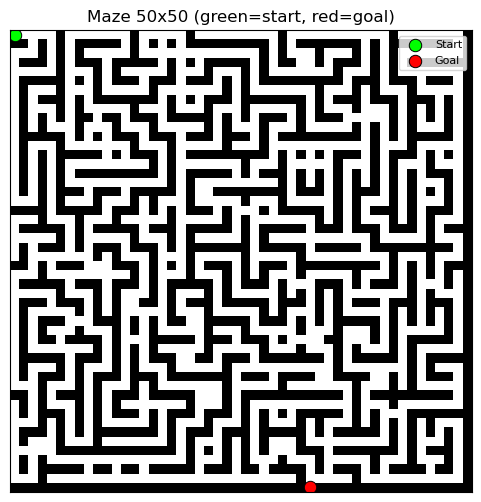

(50, 50)

In [4]:
maze = Maze(size=50, seed=35)
maze.add_loops(loop_factor=0.08)   # <- multiple routes
maze.set_goal("edge")          # options are ("edge"/random")
maze.show()

reward_grid = maze.make_reward_grid(1000)
reward_grid.shape

# Maze Agent 1

In [6]:
#scaling max step int(maze.size * (5 + np.log1p(maze.size))) depending on maze size

In [7]:
import time
import numpy as np
from IPython.display import clear_output, display
import pandas as pd

# actions: 0=up, 1=right, 2=down, 3=left
ACTIONS = [( -1, 0 ), (0, 1), (1, 0), (0, -1)]

class MazeEnv:
    def __init__(self, maze: Maze, step_penalty=-1, goal_reward=1000):
        self.maze = maze
        self.n = maze.size
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.state = None

    def reset(self):
        self.state = self.maze.start
        return self.state
    
    def step(self, action):
        r, c = self.state
        dr, dc = ACTIONS[action]
        nr, nc = r + dr, c + dc

        # stay in bounds
        if 0 <= nr < self.n and 0 <= nc < self.n and self.maze.grid[nr, nc] == 0:
            new_state = (nr, nc)
        else:
            # hit wall → stay
            new_state = (r, c)

        reward = self.step_penalty
        done = False
        if new_state == self.maze.goal:
            reward = self.goal_reward
            done = True
        
        self.state = new_state
        return new_state, reward, done, {}
    
    def get_state_index(self, state):
        # flatten (r,c) → 0..n*n-1
        r, c = state
        return r * self.n + c


In [8]:
def train_q_learning(env: MazeEnv,
                     episodes=2000,
                     alpha=0.1,
                     gamma=0.95,
                     eps_start=1.0,
                     eps_end=0.05,
                     eps_decay=0.995):
    n_states = env.n * env.n
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=float)
    eps = eps_start

    total_steps_all = 0
    visited_all = set()   # 👈 NEW: all tiles ever visited during training

    for ep in range(episodes):
        state = env.reset()
        done = False
        steps_this_ep = 0

        # mark start as visited
        visited_all.add(state)

        while not done:
            steps_this_ep += 1

            s_idx = env.get_state_index(state)

            # epsilon-greedy
            if np.random.rand() < eps:
                action = np.random.randint(n_actions)
            else:
                action = np.argmax(Q[s_idx])

            next_state, reward, done, _ = env.step(action)

            # record globally visited
            visited_all.add(next_state)

            ns_idx = env.get_state_index(next_state)

            # Q-learning update
            best_next = np.max(Q[ns_idx])
            Q[s_idx, action] = Q[s_idx, action] + alpha * (
                reward + gamma * best_next - Q[s_idx, action]
            )

            state = next_state

        # after episode ends, add to total
        total_steps_all += steps_this_ep

        # decay epsilon
        eps = max(eps_end, eps * eps_decay)

    # now return the visited set too
    return Q, total_steps_all, visited_all


In [9]:
import matplotlib.pyplot as plt

def show_visited_tiles(maze, visited_all):
    """
    Static visualization after training:
    - walls = black
    - paths = white
    - visited tiles = yellow
    - start = green
    - goal = red
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(maze.grid, cmap="gray_r")

    # visited tiles overlay
    for (r, c) in visited_all:
        ax.scatter(c, r, c='gold', s=20, alpha=0.7)

    # start / goal
    sr, sc = maze.start
    ax.scatter(sc, sr, c='lime', s=80, edgecolors='black', linewidths=0.7, label='Start')

    if maze.goal is not None:
        gr, gc = maze.goal
        ax.scatter(gc, gr, c='red', s=80, edgecolors='black', linewidths=0.7, label='Goal')

    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Tiles visited during training")
    ax.legend(loc='upper right', fontsize=8)
    plt.show()


In [10]:
def play_episode_visual(env: MazeEnv, Q, delay=0.001, max_steps=300):
    state = env.reset()
    n_actions = 4
    visited = set([state])
    step_logs = []

    for t in range(max_steps):
        clear_output(wait=True)

        s_idx = env.get_state_index(state)
        action = np.argmax(Q[s_idx])
        next_state, reward, done, _ = env.step(action)
        visited.add(next_state)

        # log decision data
        step_logs.append({
            "step": t,
            "state": state,
            "action": action,
            "next_state": next_state,
            "reward": reward,
            "Q(s,a)": Q[s_idx, action]
        })

        # draw the maze with trace
        fig, ax = plt.subplots(figsize=(6,6))
        grid_vis = env.maze.grid.copy()
        ax.imshow(grid_vis, cmap="gray_r")

        # draw visited trail (yellow)
        for (r, c) in visited:
            ax.scatter(c, r, c='gold', s=20, alpha=0.6)

        # draw start and goal
        sr, sc = env.maze.start
        gr, gc = env.maze.goal
        ax.scatter(sc, sr, c='lime', s=80, label='Start', edgecolors='black', linewidths=0.7)
        ax.scatter(gc, gr, c='red', s=80, label='Goal', edgecolors='black', linewidths=0.7)

        # draw current agent
        ar, ac = next_state
        ax.scatter(ac, ar, c='deepskyblue', s=80, label='Agent', edgecolors='black', linewidths=0.7)

        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"Step {t} | Agent at {next_state} | Visited: {len(visited)} cells")
        ax.legend(loc='upper right', fontsize=8)
        plt.show()

        # show recent steps as table
        df = pd.DataFrame(step_logs[-8:])
        display(df)

        state = next_state
        time.sleep(delay)

        if done:
            print(f"Goal reached in {t+1} steps!")
            return t + 1   #returns the step count

    print("Did not reach goal within max_steps")
    return max_steps


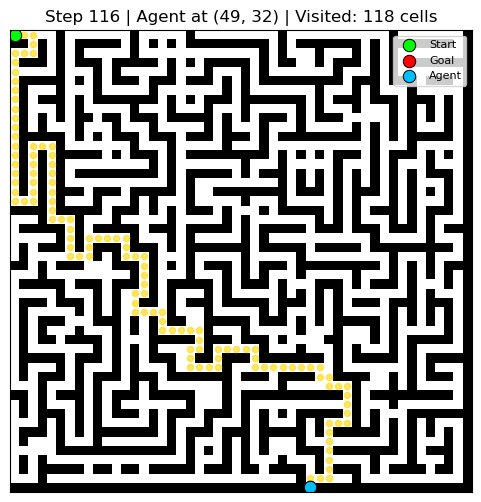

,step,state,action,next_state,reward,"Q(s,a)"
0,109,"(43, 34)",2,"(44, 34)",-1,692.304042
1,110,"(44, 34)",2,"(45, 34)",-1,729.793728
2,111,"(45, 34)",2,"(46, 34)",-1,769.256556
3,112,"(46, 34)",2,"(47, 34)",-1,810.796375
4,113,"(47, 34)",2,"(48, 34)",-1,854.522500
5,114,"(48, 34)",3,"(48, 33)",-1,900.550000
6,115,"(48, 33)",3,"(48, 32)",-1,949.000000
7,116,"(48, 32)",2,"(49, 32)",1000,1000.000000


Goal reached in 117 steps!
Final greedy run steps: 117
Total steps taken across ALL training episodes: 2132137


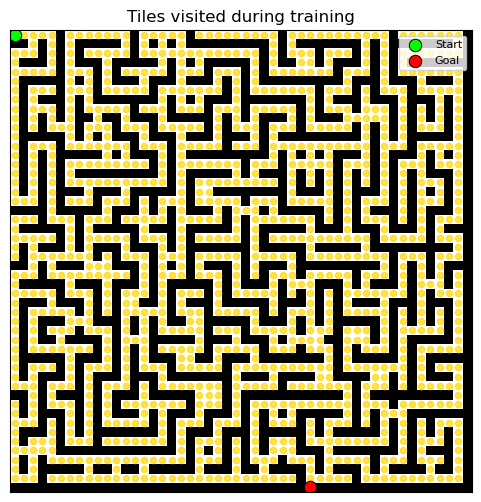

In [11]:
env = MazeEnv(maze, step_penalty=-1, goal_reward=1000)

Q, total_steps_all, visited_all = train_q_learning(env, episodes=2000)

# final greedy run
steps_taken = play_episode_visual(env, Q, delay=0.001, max_steps=300)
print("Final greedy run steps:", steps_taken)
print("Total steps taken across ALL training episodes:", total_steps_all)
# static view of everywhere agent went during training
show_visited_tiles(maze, visited_all)

# it seems that it keeps revisiting tiles. now wil implement anti-revisit penalty/shaping

Plain Q-learning: “all steps are the same until I hit 1000” → agent doesn’t care where it goes.

Shaped Q-learning: “new tile good, old tile bad” → agent quickly pushes outward

# Agent 2

In [14]:
from collections import deque
import numpy as np

def train_q_learning_agent2(
    env: MazeEnv,
    episodes=2000,
    alpha=0.1,
    gamma=0.95,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    max_steps_per_episode=300,
    visit_bonus=0.2,
    revisit_penalty=-0.5,
    backtrack_penalty=-0.8,
    stay_penalty=-0.4,
    shortloop_penalty=-0.6,
    loop_window=4
):
    n_states = env.n * env.n
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=float)
    eps = eps_start

    total_steps_all = 0
    visited_all = set()   

    for ep in range(episodes):
        state = env.reset()
        done = False
        steps_this_ep = 0

        visited_this_ep = set([state])
        recent_states = deque([state], maxlen=loop_window)
        prev_state = None

        # also record start as visited
        visited_all.add(state)

        while (not done) and (steps_this_ep < max_steps_per_episode):
            steps_this_ep += 1

            s_idx = env.get_state_index(state)

            # epsilon-greedy
            if np.random.rand() < eps:
                action = np.random.randint(n_actions)
            else:
                best_actions = np.argwhere(Q[s_idx] == np.max(Q[s_idx])).flatten()
                action = np.random.choice(best_actions)

            next_state, reward, done, _ = env.step(action)

            # mark globally visited
            visited_all.add(next_state)

            # shaping
            if next_state == state:
                reward += stay_penalty

            if next_state not in visited_this_ep:
                reward += visit_bonus
                visited_this_ep.add(next_state)
            else:
                reward += revisit_penalty

            if prev_state is not None and next_state == prev_state:
                reward += backtrack_penalty

            if next_state in recent_states and next_state != state:
                reward += shortloop_penalty

            recent_states.append(next_state)

            ns_idx = env.get_state_index(next_state)
            best_next = np.max(Q[ns_idx])

            Q[s_idx, action] = Q[s_idx, action] + alpha * (
                reward + gamma * best_next - Q[s_idx, action]
            )

            prev_state = state
            state = next_state

            if done:
                break

        total_steps_all += steps_this_ep
        eps = max(eps_end, eps * eps_decay)

    # return visited_all too 
    return Q, total_steps_all, visited_all


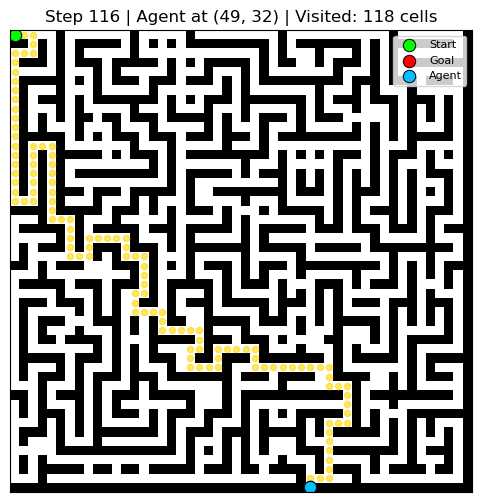

,step,state,action,next_state,reward,"Q(s,a)"
0,109,"(43, 34)",2,"(44, 34)",-1,693.421839
1,110,"(44, 34)",2,"(45, 34)",-1,730.824876
2,111,"(45, 34)",2,"(46, 34)",-1,770.226666
3,112,"(46, 34)",2,"(47, 34)",-1,811.653709
4,113,"(47, 34)",2,"(48, 34)",-1,855.247607
5,114,"(48, 34)",3,"(48, 33)",-1,901.117444
6,115,"(48, 33)",3,"(48, 32)",-1,949.389937
7,116,"(48, 32)",2,"(49, 32)",1000,1000.200000


Goal reached in 117 steps!
Final greedy run steps (Agent 2): 117
Total steps across all episodes (Agent 2): 514196


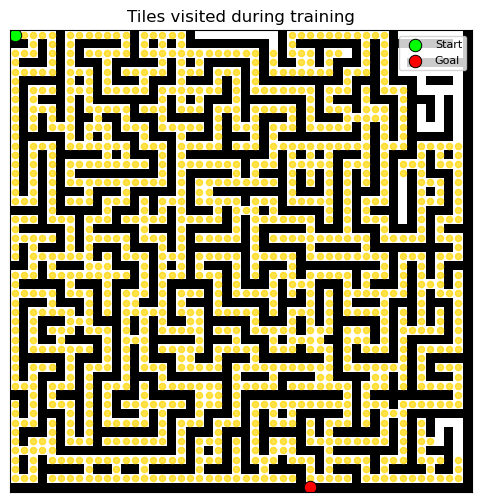

In [15]:
env = MazeEnv(maze, step_penalty=-1, goal_reward=1000)

# train smarter agent
Q2, total_steps_all, visited_all = train_q_learning_agent2(
    env,
    episodes=2000,
    max_steps_per_episode=300
)




# visualize final greedy run using your existing function
steps_taken = play_episode_visual(env, Q2, delay=0.01, max_steps=int(maze.size * (5 + np.log1p(maze.size))))
print("Final greedy run steps (Agent 2):", steps_taken)
print("Total steps across all episodes (Agent 2):", total_steps_all)
show_visited_tiles(maze, visited_all)

## comparison

default q learning : Total steps taken across ALL training episodes: 2068446

with anti-revisit/shaping :Total steps across all episodes (Agent 2): 639870

cost significantly reduced

# Agent 3

try to solve maze without having to search through entire maze

Agent 2 has episode-level curiosity (visit bonus), which is good early, but it never turns off.

So even after it finds the goal, it keeps exploring other branches, which is unnecessary if your objective is “fastest route”.

Also, the shaping is exploration-oriented not goal-oriented.

So we want these improvements:

    Success-aware epsilon drop

        The moment the agent reaches the goal in any episode, we can slam ε down from (say) 0.8 → 0.1 or 0.05.

        That stops wide exploration.

    Turn off visit bonus after goal is discovered

        Early = explore → visit_bonus > 0

        After goal found once = focus → visit_bonus = 0, keep only step penalty.

        That alone fixes a lot.

    Episode length shrink after goal discovered

        Before goal: max_steps_per_episode = 800

        After goal: max_steps_per_episode = best_path_len * 2

        So it can’t waste 800 steps wandering.

    Best-trajectory replay

        Every time it reaches the goal, store that trajectory.

        If the new one is shorter → overwrite.

        Keep training with that data (Q-learning from experience) without having to re-explore the whole maze.

These 4 ideas let us find the fastest path without visiting every tile.

In [18]:
from collections import deque
import numpy as np

def train_q_learning_agent3(
    env: MazeEnv,
    episodes=2000,
    alpha=0.1,
    gamma=0.95,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    max_steps_per_episode=300,   
    visit_bonus=0.2,
    revisit_penalty=-0.5,
    backtrack_penalty=-0.8,
    stay_penalty=-0.4,
    shortloop_penalty=-0.6,
    loop_window=4,
    min_ep_steps = int(maze.size * 3),          
    successes_before_tighten=3   # only tighten after a few successes
):
    n_states = env.n * env.n
    Q = np.zeros((n_states, 4), dtype=float)
    eps = eps_start

    total_steps_all = 0
    visited_all = set()

    goal_discovered = False
    best_len = None
    success_count = 0

    for ep in range(episodes):
        state = env.reset()
        done = False

        visited_this_ep = set([state])
        recent_states = deque([state], maxlen=loop_window)
        prev_state = None

        visited_all.add(state)

        # decide per-episode params
        if goal_discovered and success_count >= successes_before_tighten and best_len is not None:
            # tighten, but not too much
            ep_max_steps = max(min_ep_steps, min(max_steps_per_episode, best_len * 2))
            eps_eff = max(eps_end, eps * 0.5)   # lower, but not dead
            ep_visit_bonus = visit_bonus * 0.5  # reduced curiosity
        else:
            ep_max_steps = max_steps_per_episode
            eps_eff = eps
            ep_visit_bonus = visit_bonus

        steps_this_ep = 0

        while (not done) and (steps_this_ep < ep_max_steps):
            steps_this_ep += 1

            s_idx = env.get_state_index(state)

            # epsilon-greedy with tie-breaking
            if np.random.rand() < eps_eff:
                action = np.random.randint(4)
            else:
                best_actions = np.argwhere(Q[s_idx] == np.max(Q[s_idx])).flatten()
                action = np.random.choice(best_actions)

            next_state, reward, done, _ = env.step(action)
            visited_all.add(next_state)

            # shaping
            if next_state == state:
                reward += stay_penalty

            if next_state not in visited_this_ep:
                reward += ep_visit_bonus
                visited_this_ep.add(next_state)
            else:
                reward += revisit_penalty

            if prev_state is not None and next_state == prev_state:
                reward += backtrack_penalty

            if next_state in recent_states and next_state != state:
                reward += shortloop_penalty

            recent_states.append(next_state)

            ns_idx = env.get_state_index(next_state)
            best_next = np.max(Q[ns_idx])

            Q[s_idx, action] = Q[s_idx, action] + alpha * (
                reward + gamma * best_next - Q[s_idx, action]
            )

            prev_state = state
            state = next_state

            if done:
                # reached goal
                success_count += 1
                goal_discovered = True
                if best_len is None or steps_this_ep < best_len:
                    best_len = steps_this_ep
                break

        total_steps_all += steps_this_ep

        # normal epsilon decay
        eps = max(eps_end, eps * eps_decay)

    # return everything like before
    return Q, total_steps_all, visited_all, best_len


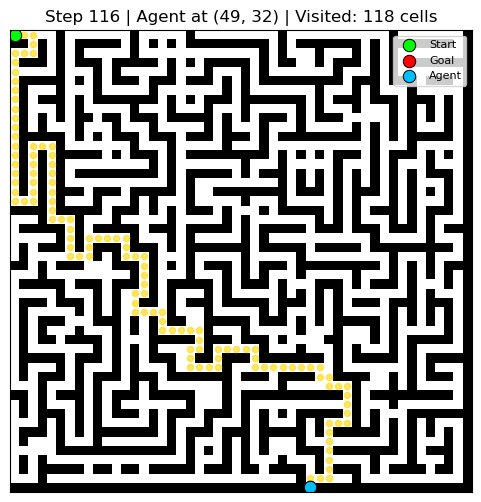

,step,state,action,next_state,reward,"Q(s,a)"
0,109,"(43, 34)",2,"(44, 34)",-1,698331.007523
1,110,"(44, 34)",2,"(45, 34)",-1,735086.339368
2,111,"(45, 34)",2,"(46, 34)",-1,773776.057433
3,112,"(46, 34)",2,"(47, 34)",-1,814502.090645
4,113,"(47, 34)",2,"(48, 34)",-1,857371.608579
5,114,"(48, 34)",3,"(48, 33)",-1,902497.411744
6,115,"(48, 33)",3,"(48, 32)",-1,949998.240887
7,116,"(48, 32)",2,"(49, 32)",999999,999999.100000


Goal reached in 117 steps!
Final greedy run steps (Agent 3): 117
Total steps across all episodes (Agent 3): 501919
Best path length found (Agent 3): 117


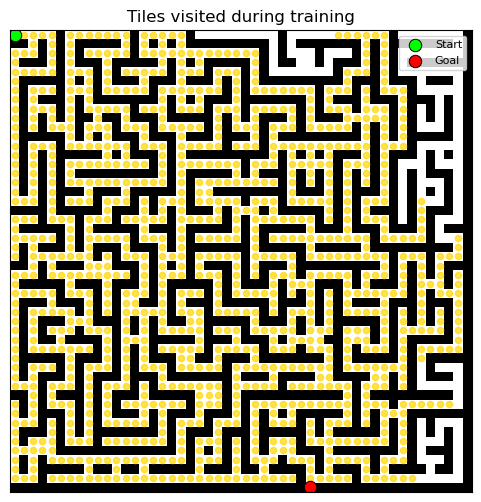

In [19]:
env = MazeEnv(maze, step_penalty=-1, goal_reward=999999)

Q3, total_steps_all, visited_all, best_len = train_q_learning_agent3(
    env,
    episodes=2000,
    max_steps_per_episode=300
)



# optional: final run
steps_taken = play_episode_visual(env, Q3, delay=0.01, max_steps=300)
print("Final greedy run steps (Agent 3):", steps_taken)
print("Total steps across all episodes (Agent 3):", total_steps_all)
print("Best path length found (Agent 3):", best_len)

# optional: static training coverage
show_visited_tiles(maze, visited_all)
